In [4]:
import os
import random
from matplotlib import pyplot as plt
import cv2

import numpy as np
import pandas as pd

from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.metrics import Precision, Recall

import keras_tuner as kt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [5]:
top_dir = 'C:/Users/coco/Untitled Folder'
train_dir = top_dir + '/train'
test_dir = top_dir + '/test'

train_real = os.listdir(train_dir + '/REAL')
train_fake = os.listdir(train_dir + '/FAKE')

In [6]:
# Plot k-number of images from the dataset

def plot_im(directory, k):

    files = os.listdir(directory)
    im = random.choices(files, k = k)

    fig = plt.figure()

    for i in range(k):
        im_i = cv2.imread(directory + im[i])
        fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        plt.imshow(im_i)
        plt.axis('off')
    
    return plt

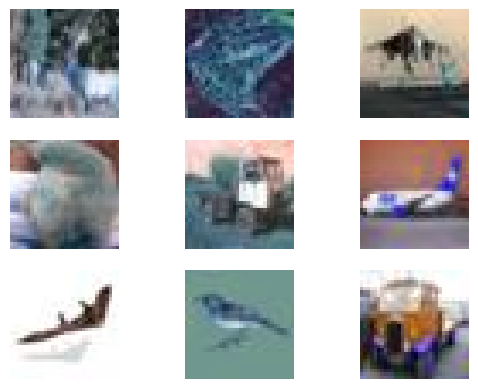

In [7]:
real_im = plot_im(directory = train_dir + '/REAL/', k = 9)

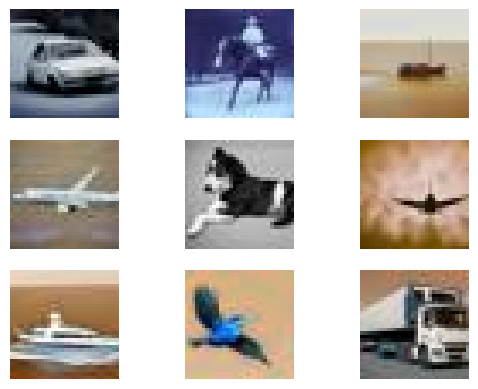

In [8]:
fake_im = plot_im(directory = train_dir + '/FAKE/', k = 9)

In [9]:
# Generate tf datasets

train = image_dataset_from_directory(
    train_dir,
    label_mode = 'binary',
    image_size = (32, 32)
)

test = image_dataset_from_directory(
    test_dir,
    label_mode = 'binary',
    image_size = (32, 32)
)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [10]:
simple_model = Sequential([
    Rescaling(scale = 1./255),
    Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units = 64),
    BatchNormalization(),
    Activation('relu'),
    Dense(units = 1, activation = 'sigmoid')
])

simple_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', Precision(), Recall()]
)

simple_model.fit(train, validation_data = test, epochs = 5)

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 75s 23ms/step - accuracy: 0.8521 - loss: 0.3378 - precision: 0.8496 - recall: 0.8529 - val_accuracy: 0.7082 - val_loss: 0.6587 - val_precision: 0.9957 - val_recall: 0.4183
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - accuracy: 0.9123 - loss: 0.2164 - precision: 0.9103 - recall: 0.9138 - val_accuracy: 0.8600 - val_loss: 0.3534 - val_precision: 0.7894 - val_recall: 0.9820
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 71s 23ms/step - accuracy: 0.9238 - loss: 0.1882 - precision: 0.9217 - recall: 0.9258 - val_accuracy: 0.9063 - val_loss: 0.2333 - val_precision: 0.9523 - val_recall: 0.8554
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 72s 23ms/step - accuracy: 0.9333 - loss: 0.1702 - precision: 0.9316 - recall: 0.9346 - val_accuracy: 0.9310 - val_loss: 0.1755 - val_precision: 0.9118 - val_recall: 0.9543
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.9402 - loss: 0.1554 - precision: 0.9385 - recall: 0.9418 - val_accuracy: 0.9275

In [11]:
# Hyperparameter tuning with keras_tuner

def model_builder(hp):
    
    # Hyperparameters
    dense_units = hp.Int('dense_units', min_value = 16, max_value = 128, step = 16)
    conv2d_filters_0 = hp.Int('conv_filters_0', min_value = 16, max_value = 128, step = 16)
    conv2d_filters_1 = hp.Int('conv_filters_1', min_value = 16, max_value = 128, step = 16)
    dropout_rate = hp.Int('dropout_rate', min_value = 0, max_value = 5, step = 1)
    learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    
    model = Sequential([
        Rescaling(scale = 1./255),
        Conv2D(filters = conv2d_filters_0, kernel_size = 3, activation = 'relu'),
        MaxPooling2D(),
        Conv2D(filters = conv2d_filters_1, kernel_size = 3, activation = 'relu'),
        MaxPooling2D(),
        Dropout(rate = dropout_rate/10),
        Flatten(),
        Dense(units = dense_units),
        BatchNormalization(),
        Activation('relu'),
        Dense(units = 1, activation = 'sigmoid')
    ])
    
    model.compile(
        optimizer = Adam(learning_rate = learning_rate),
        loss = 'binary_crossentropy',
        metrics = ['accuracy', Precision(), Recall()]
    )
    
    return model

In [12]:
# Optimize model for validation accuracy

stop_early = EarlyStopping(monitor = 'val_accuracy', patience = 3)

tuner = kt.Hyperband(
    hypermodel = model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'tuning',
    overwrite = True
)

tuner.search(
    train,
    validation_data = test,
    callbacks = [stop_early]
)

Trial 30 Complete [00h 10m 21s]
val_accuracy: 0.9369000196456909

Best val_accuracy So Far: 0.9488000273704529
Total elapsed time: 02h 40m 21s


In [13]:
optimal_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(optimal_hps)

history = model.fit(
    train,
    validation_data = test,
    epochs = 20,
    callbacks = [stop_early]
)

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 89s 27ms/step - accuracy: 0.7996 - loss: 0.4318 - precision_3: 0.7911 - recall_3: 0.8103 - val_accuracy: 0.8865 - val_loss: 0.2705 - val_precision_3: 0.8360 - val_recall_3: 0.9617
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 84s 27ms/step - accuracy: 0.9037 - loss: 0.2442 - precision_3: 0.9009 - recall_3: 0.9062 - val_accuracy: 0.9000 - val_loss: 0.2349 - val_precision_3: 0.8495 - val_recall_3: 0.9723
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 84s 27ms/step - accuracy: 0.9209 - loss: 0.2030 - precision_3: 0.9194 - recall_3: 0.9219 - val_accuracy: 0.9233 - val_loss: 0.1907 - val_precision_3: 0.8899 - val_recall_3: 0.9662
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - accuracy: 0.9304 - loss: 0.1793 - precision_3: 0.9279 - recall_3: 0.9328 - val_accuracy: 0.9277 - val_loss: 0.1793 - val_precision_3: 0.8959 - val_recall_3: 0.9680
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 113s 36ms/step - accuracy: 0.9363 - loss: 0.1651 - precision_3: 0.9341

In [15]:
model.summary()
model.save('AIdetect.keras')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        55,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,301 (1.61 MB)

 Trainable params: 141,089 (551.13 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 282,180 (1.08 MB)